In [ ]:
dataset_ver = 3

In [ ]:
# !pip install torchinfo

In [ ]:
# from google.colab import drive
import zipfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import io
import contextlib
import copy
import shutil
import re
from torch.utils.data import Subset
import torch.nn.functional as F
from tqdm import tqdm
import time

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = "/content/drive/MyDrive/FYP/datasets/" + str(dataset_ver) + "/BlenderOutputs_Sim.zip"

extract_dir = "/content/dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction complete. Files are in:", extract_dir)

✅ Extraction complete. Files are in: /content/dataset


In [6]:
zip_path = "/content/drive/MyDrive/FYP/datasets/"+str(dataset_ver)+ "/displacements.zip"

extract_dir = "/content/dataset/displacements"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction complete. Files are in:", extract_dir)

✅ Extraction complete. Files are in: /content/dataset/displacements


In [7]:
# ================================
# 1. Dataset
# ================================
class FlagWindDataset(Dataset):
    def __init__(self, data_dir, target_dir, max_frames=280, iterations=100, sequence_length=10):
        self.samples = []
        self.data_dir = data_dir
        self.target_dir = target_dir
        self.sequence_length = sequence_length

        # Stats containers
        self.flag_mean = None
        self.flag_std = None
        self.disp_mean = None
        self.disp_std = None
        self.wind_mean = None
        self.wind_std = None

        # Populate samples with (iteration, start_frame)
        for iteration in range(1, iterations + 1):
            for start_frame in range(1, max_frames - sequence_length + 2):
                flag_file = os.path.join(data_dir, f"flag_{iteration:03d}_{start_frame:03d}.npy")
                if os.path.exists(flag_file):
                    self.samples.append((iteration, start_frame))

    def set_stats(self, flag_mean, flag_std, disp_mean, disp_std, wind_mean, wind_std):
        self.flag_mean = flag_mean
        self.flag_std = flag_std
        self.disp_mean = disp_mean
        self.disp_std = disp_std
        self.wind_mean = wind_mean
        self.wind_std = wind_std

    def __len__(self):
        return len(self.samples)

    def load_raw_frame(self, iteration, frame):
        # Helper to load raw data
        flag = np.load(os.path.join(self.data_dir, f"flag_{iteration:03d}_{frame:03d}.npy")).astype(np.float32)
        wind = np.load(os.path.join(self.data_dir, f"wind_{iteration:03d}_{frame:03d}.npy")).astype(np.float32)
        disp = np.load(os.path.join(self.target_dir, f"displacement_{iteration:03d}_{frame:03d}.npy")).astype(np.float32)
        return flag, wind, disp

    def __getitem__(self, idx):
        iteration, start_frame = self.samples[idx]

        flag_seq = []
        wind_seq = []
        disp_seq = []

        # Load sequence of length L
        for frame in range(start_frame, start_frame + self.sequence_length):
            flag, wind, disp = self.load_raw_frame(iteration, frame)

            # Normalize
            if self.flag_mean is not None:
                flag = (flag - self.flag_mean) / (self.flag_std + 1e-8)
                wind = (wind - self.wind_mean) / (self.wind_std + 1e-8)
                disp = (disp - self.disp_mean) / (self.disp_std + 1e-8)

            # Append UNFLATTENED arrays
            flag_seq.append(flag) # (1024, 3)
            wind_seq.append(wind) # (8, 3)
            disp_seq.append(disp) # (1024, 3)

        # Stack into tensors: (L, 1024, 3), (L, 8, 3), etc.
        return (torch.from_numpy(np.stack(flag_seq)),
                torch.from_numpy(np.stack(wind_seq)),
                torch.from_numpy(np.stack(disp_seq)))

In [8]:
def SplitDataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

In [9]:
def SplitDatasetByIteration(dataset: Dataset, train_ratio=0.8):
    """
    Split a SequentialFlagWindDataset deterministically by iteration index.
    First train_ratio * total_iters iterations go to train, rest to test.

    Args:
        dataset (SequentialFlagWindDataset): The dataset object to split.
        train_ratio (float): Ratio of iterations to allocate to the training set.

    Returns:
        (SequentialFlagWindDataset, SequentialFlagWindDataset): Train and Test datasets.
    """

    # 1. Detect total unique iterations from dataset.samples
    # The new samples are (iteration, start_frame)
    iters = sorted(set(iteration for iteration, _ in dataset.samples))
    if not iters:
        raise ValueError("Dataset has no samples to split.")

    total_iters = max(iters)

    # Calculate the threshold for splitting
    train_iters_count = int(train_ratio * total_iters)
    train_iters_limit = iters[train_iters_count - 1] if train_iters_count > 0 else 0

    print(f"Total iterations found: {total_iters}")
    print(f"Train iterations count: {train_iters_count}. Train iteration limit (inclusive): {train_iters_limit}")

    train_samples, test_samples = [], []

    # 2. Assign samples (iteration, start_frame) based on iteration index
    for iteration, start_frame in dataset.samples:
        if iteration <= train_iters_limit:
            train_samples.append((iteration, start_frame))
        else:
            test_samples.append((iteration, start_frame))

    # 3. Create deep copies of the dataset and update their samples list.
    # We use copy.copy() (shallow copy) to maintain the original dataset's
    # configuration (data_dir, sequence_length, stats pointers)

    train_dataset = copy.copy(dataset)
    test_dataset = copy.copy(dataset)

    # 4. Assign the filtered samples
    train_dataset.samples = train_samples
    test_dataset.samples = test_samples

    print(f"Train samples size: {len(train_samples)}")
    print(f"Test samples size: {len(test_samples)}")

    return train_dataset, test_dataset

In [10]:
# ================================
# 1. Core Spatial Fusion Module (Single Timestep)
# ================================
class SequentialCNNFlagWindNet(nn.Module):
    def __init__(self, flag_h= 32, flag_w = 32, num_wind_points=8, hidden_dim=128):
        super().__init__()

        # Grid dimensions (Assumed 32x32 = 1024)
        self.grid_h = flag_h
        self.grid_w = flag_w

        # 1. CNN Flag Encoder (Takes 32x32x3 image structure)
        # Input: (Batch, 3, 32, 32) -> Output: Flattened Vector
        self.flag_encoder = nn.Sequential(
            # Conv Block 1: 3 -> 16
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # Output: 16 x 16 x 16

            # Conv Block 2: 16 -> 32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Output: 32 x 8 x 8

            # Conv Block 3: 32 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Output: 64 x 4 x 4

            # Flatten final feature map
            nn.Flatten(),
            # Project to latent dim (64 * 4 * 4 = 1024)
            nn.Linear(64 * 4 * 4, hidden_dim)
        )

        # 2. Wind Encoder (MLP)
        self.wind_flat_dim = num_wind_points * 3
        self.wind_encoder = nn.Sequential(
            nn.Linear(self.wind_flat_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)
        )

        # LSTM input size = Flag Latent + Wind Latent
        self.lstm_input_dim = hidden_dim + (hidden_dim // 4)

        # 3. Temporal Processing
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )

        # ==========================================
        # 4. DECODER (4x4 -> 32x32)
        # ==========================================

        # Step A: Project LSTM Hidden State back to Spatial Feature Map Size
        # We need to get back to (64 channels, 4 height, 4 width)
        self.decoder_projection = nn.Linear(hidden_dim, 64 * 4 * 4)

        # Step B: Transpose Convolutions to Upsample
        self.decoder_cnn = nn.Sequential(
            # Unflatten happen manually in forward()

            # Block 1: 4x4 -> 8x8
            # Input: (B, 64, 4, 4)
            nn.ConvTranspose2d(in_channels=64, out_channels=32,
                               kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Block 2: 8x8 -> 16x16
            # Input: (B, 32, 8, 8)
            nn.ConvTranspose2d(in_channels=32, out_channels=16,
                               kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Block 3: 16x16 -> 32x32
            # Input: (B, 16, 16, 16)
            # Output channels = 3 (dx, dy, dz)
            nn.ConvTranspose2d(in_channels=16, out_channels=3,
                               kernel_size=4, stride=2, padding=1)

            # No final activation (Regression output can be pos or neg)
        )

    def forward(self, x_flag_seq, x_wind_seq):
        # x_flag_seq: (B, L, 1024, 3)
        # x_wind_seq: (B, L, 8, 3)

        B, L, N, D = x_flag_seq.shape

        # --- 1. PREPARE INPUTS ---
        # Reshape to (B*L, 3, 32, 32)
        x_flag_img = x_flag_seq.view(B * L, self.grid_h, self.grid_w, 3).permute(0, 3, 1, 2)
        x_wind_flat = x_wind_seq.view(B * L, -1)

        # --- 2. ENCODE ---
        # Flag: CNN -> Flatten -> Linear
        # The encoder now outputs the latent vector directly
        flag_latent = self.flag_encoder(x_flag_img)    # (B*L, hidden_dim)

        # Wind: MLP
        wind_latent = self.wind_encoder(x_wind_flat)   # (B*L, hidden_dim//4)

        # --- 3. LSTM ---
        # Combine Latents
        combined = torch.cat([flag_latent, wind_latent], dim=1) # (B*L, H + H/4)

        # Reshape for LSTM: (B, L, Input_Size)
        lstm_in = combined.view(B, L, -1)

        # Run LSTM
        lstm_out, _ = self.lstm(lstm_in) # Output: (B, L, hidden_dim)

        # --- 4. DECODE ---
        # Flatten time dim again: (B*L, hidden_dim)
        lstm_out_flat = lstm_out.reshape(B * L, -1)

        # Project back to feature map size: (B*L, 64*4*4)
        decoder_input = self.decoder_projection(lstm_out_flat)

        # Unflatten to 4x4 spatial map: (B*L, 64, 4, 4)
        decoder_input_map = decoder_input.view(B * L, 64, 4, 4)

        # Run Transpose Convs: Output (B*L, 3, 32, 32)
        spatial_output = self.decoder_cnn(decoder_input_map)

        # --- 5. FORMAT OUTPUT ---
        # (B*L, 3, 32, 32) -> (B*L, 32, 32, 3) -> (B, L, 1024, 3)
        output_seq = spatial_output.permute(0, 2, 3, 1).reshape(B, L, N, D)

        return output_seq

# ================================
# 2. Sequential Model
# ================================
class SequentialFlagWindNet(nn.Module):
    def __init__(self, num_flag_points=1024,
                 num_wind_points=8, hidden_dim=128):
        super().__init__()

        # Dimensions
        self.flag_flat_dim = num_flag_points * 3
        self.wind_flat_dim = num_wind_points * 3

        # 1. Input Compression
        # FIXED: Added commas between layers
        self.flag_encoder = nn.Sequential(
            nn.Linear(self.flag_flat_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)
        )

        # FIXED: Input to 2nd layer matches output of 1st layer (hidden_dim // 4)
        self.wind_encoder = nn.Sequential(
            nn.Linear(self.wind_flat_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 8)
        )

        # LSTM input size = (H/4) + (H/8) = 3H/8
        self.lstm_input_dim = (hidden_dim // 4) + (hidden_dim // 8)

        # 2. Temporal Processing
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )

        # 3. Decoder
        # FIXED: The decoder must map the LSTM Output (hidden_dim)
        # back to the full flag size (1024 * 3).
        # We cannot reuse 'FlagWindSpatialFusionNet' here because that net
        # expects raw 3D coordinates, but we have a compressed LSTM vector.
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, self.flag_flat_dim) # Output: 3072
        )

    def forward(self, x_flag_seq, x_wind_seq):
        # x_flag_seq: (B, L, 1024, 3)
        # x_wind_seq: (B, L, 8, 3)
        B, L, N, D = x_flag_seq.shape

        # Flatten
        flag_flat = x_flag_seq.reshape(B*L, -1)
        wind_flat = x_wind_seq.reshape(B*L, -1)

        # Encode
        flag_enc = self.flag_encoder(flag_flat) # (B*L, H/4)
        wind_enc = self.wind_encoder(wind_flat) # (B*L, H/8)

        # Combine
        combined = torch.cat([flag_enc, wind_enc], dim=1) # (B*L, 3H/8)

        # Reshape for LSTM
        lstm_in = combined.reshape(B, L, -1)

        # LSTM Pass
        lstm_out, _ = self.lstm(lstm_in) # (B, L, H)

        # Decode from LSTM output
        lstm_out_flat = lstm_out.reshape(B*L, -1)

        # FIXED: Decoder uses the LSTM output
        disp_flat = self.decoder(lstm_out_flat)

        # Reshape back to sequence
        return disp_flat.reshape(B, L, N, D)

In [20]:
def train_model(train_set, val_set, batch_size=32, epochs=10, lr=1e-3, device="cuda"):
    """
    Trains the SequentialCNNFlagWindNet model using sequence-to-sequence data with SEPARATE inputs.
    """

    # --- Data Loaders ---
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # --- Model and Hyperparameters ---
    model = SequentialCNNFlagWindNet(
        flag_h=32,
        flag_w=32,
        num_wind_points=8,
        hidden_dim=128
    ).to(device)

    # L1Loss (Mean Absolute Error)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # --- History Tracking ---
    train_loss_history = []
    val_loss_history = []

    print(f"Starting training on device: {device}")
    print(f"Model: SequentialCNNFlagWindNet")

    # =================================================================
    # Training Loop
    # =================================================================
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", unit="batch")

        for x_flag_seq, x_wind_seq, y_seq in train_pbar:
            x_flag_seq = x_flag_seq.to(device)
            x_wind_seq = x_wind_seq.to(device)
            y_seq = y_seq.to(device)

            optimizer.zero_grad()

            # Prediction
            pred_seq = model(x_flag_seq, x_wind_seq)

            # --- FIX: Use .reshape(-1) instead of .view(-1) ---
            loss = criterion(pred_seq.reshape(-1), y_seq.reshape(-1))

            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            running_train_loss += current_loss
            train_pbar.set_postfix({'Loss': f'{current_loss:.6f}'})

        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # =================================================================
        # Validation Phase
        # =================================================================
        model.eval()
        running_val_loss = 0.0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Val)", unit="batch")

        with torch.no_grad():
            for x_flag_seq, x_wind_seq, y_seq in val_pbar:
                x_flag_seq = x_flag_seq.to(device)
                x_wind_seq = x_wind_seq.to(device)
                y_seq = y_seq.to(device)

                pred_seq = model(x_flag_seq, x_wind_seq)

                # --- FIX: Use .reshape(-1) here as well ---
                loss = criterion(pred_seq.reshape(-1), y_seq.reshape(-1))

                current_loss = loss.item()
                running_val_loss += current_loss
                val_pbar.set_postfix({'Loss': f'{current_loss:.6f}'})

        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # --- Epoch Summary ---
        print(f"\n✨ Epoch {epoch+1}/{epochs} Summary:")
        print(f"  Train Loss: {avg_train_loss:.6f} | Validation Loss: {avg_val_loss:.6f}\n")

    return model, train_loss_history, val_loss_history

In [12]:
def flag_vis(flag, pred, margin=0.1, equal_axes=True):
    pred_flag = flag.numpy() + pred.numpy()

    fig = plt.figure(figsize=(12, 6))

    # Compute min/max for each axis
    lims = np.array([
        [min(flag[:,0].min(), pred_flag[:,0].min()), max(flag[:,0].max(), pred_flag[:,0].max())],
        [min(flag[:,1].min(), pred_flag[:,1].min()), max(flag[:,1].max(), pred_flag[:,1].max())],
        [min(flag[:,2].min(), pred_flag[:,2].min()), max(flag[:,2].max(), pred_flag[:,2].max())],
    ])

    # Add margin (10% by default)
    ranges = lims[:,1] - lims[:,0]
    lims[:,0] -= margin * ranges
    lims[:,1] += margin * ranges

    # Optionally force equal aspect ratio (cube box)
    if equal_axes:
        max_range = ranges.max()
        centers = lims.mean(axis=1)
        lims[:,0] = centers - max_range/2 * (1 + margin)
        lims[:,1] = centers + max_range/2 * (1 + margin)

    # Original
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(flag[:,0], flag[:,1], flag[:,2], c='blue', s=8, alpha=0.7)
    ax1.set_title("Original Flag")
    ax1.set_xlim(lims[0]); ax1.set_ylim(lims[1]); ax1.set_zlim(lims[2])
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
    ax1.grid(False)

    # Predicted
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pred_flag[:,0], pred_flag[:,1], pred_flag[:,2], c='red', s=8, alpha=0.7)
    ax2.set_title("Predicted Flag")
    ax2.set_xlim(lims[0]); ax2.set_ylim(lims[1]); ax2.set_zlim(lims[2])
    ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])
    ax2.grid(False)

    # Match same view
    ax2.view_init(elev=ax1.elev, azim=ax1.azim)

    plt.tight_layout()
    plt.show()

In [13]:
ds = FlagWindDataset(data_dir="/content/dataset/BlenderOutputs_Sim", target_dir="/content/dataset/displacements")

In [14]:
print("Splitting dataset by iteration...")

# Define the iteration number to split on (e.g., 80 for train, 20 for test)
split_iteration = 80
train_indices = []
test_indices = []

# Iterate through the sequential dataset's samples
# The structure is now: (iteration, start_frame)
for i, (iteration, start_frame) in enumerate(ds.samples):
    # iteration is directly available as an integer! No regex needed.
    if iteration <= split_iteration:
        train_indices.append(i)
    else:
        test_indices.append(i)

# Create the Subset objects
train_set = Subset(ds, train_indices)
test_set = Subset(ds, test_indices)

print(f"Split complete: {len(train_indices)} training samples, {len(test_indices)} test samples.")

Splitting dataset by iteration...
Split complete: 21680 training samples, 5420 test samples.


In [15]:
print("train set size:", len(train_set))
print("test set size:", len(test_set))

train set size: 21680
test set size: 5420


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Calculate Mean and Std from TRAINING set
# ==========================================
print("Calculating normalization stats from training set...")

# Use a set to track unique (iteration, frame) pairs to avoid duplicates
unique_frames = set()

# Iterate through the indices in the training Subset
for idx in train_set.indices:
    # Get the sequence definition from the main dataset
    # sample is now (iteration, start_frame)
    iteration, start_frame = train_set.dataset.samples[idx]

    # Add all frames in this sequence to our set
    for f in range(start_frame, start_frame + train_set.dataset.sequence_length):
        unique_frames.add((iteration, f))

# Containers
flag_data = []
wind_data = []
disp_data = []

print(f"Loading {len(unique_frames)} unique frames...")

# Load the raw data for every unique frame
for iteration, frame in tqdm(unique_frames):
    # USE THE CORRECT METHOD: load_raw_frame
    flag, wind, disp = train_set.dataset.load_raw_frame(iteration, frame)

    flag_data.append(flag)
    wind_data.append(wind)
    disp_data.append(disp)

# Stack and Calculate
all_flags = np.stack(flag_data) # (N_frames, 1024, 3)
all_winds = np.stack(wind_data) # (N_frames, 8, 3)
all_disps = np.stack(disp_data) # (N_frames, 1024, 3)

flag_mean = np.mean(all_flags, axis=(0, 1))
flag_std = np.std(all_flags, axis=(0, 1))

wind_mean = np.mean(all_winds, axis=(0, 1))
wind_std = np.std(all_winds, axis=(0, 1))

disp_mean = np.mean(all_disps, axis=(0, 1))
disp_std = np.std(all_disps, axis=(0, 1))

print("Stats calculated.")
print(f"Flag Mean: {flag_mean}")
print(f"Wind Mean: {wind_mean}")
print(f"Disp Mean: {disp_mean}")

# ==========================================
# 2. Set stats for the dataset
# ==========================================
# IMPORTANT: Pass NumPy arrays here, NOT Tensors.
# The __getitem__ method does math using these before converting to Tensor.
train_set.dataset.set_stats(
    flag_mean, flag_std,
    disp_mean, disp_std,
    wind_mean, wind_std
)

# ==========================================
# 3. Create Tensors for denormalization (Rollout)
# ==========================================
# These are kept separate on the GPU for the rollout function
flag_mean_tensor = torch.tensor(flag_mean, dtype=torch.float32).to(device)
flag_std_tensor = torch.tensor(flag_std, dtype=torch.float32).to(device)
disp_mean_tensor = torch.tensor(disp_mean, dtype=torch.float32).to(device)
disp_std_tensor = torch.tensor(disp_std, dtype=torch.float32).to(device)
wind_mean_tensor = torch.tensor(wind_mean, dtype=torch.float32).to(device)
wind_std_tensor = torch.tensor(wind_std, dtype=torch.float32).to(device)

# ==========================================
# 4. Create lookup dictionary for test_set
# ==========================================
print("Creating test set lookup...")
test_set_lookup = {}

# Iterate through the sequential dataset's samples
# Structure is now: (iteration, start_frame)
for i, (iteration, start_frame) in enumerate(test_set.dataset.samples):
    # Check if this index is in the test_set subset
    if i in test_set.indices:
        # Map (iteration, start_frame) -> dataset index
        test_set_lookup[(iteration, start_frame)] = i

print(f"Lookup created with {len(test_set_lookup)} sequences.")

Calculating normalization stats from training set...
Loading 22400 unique frames...


100%|██████████| 22400/22400 [00:06<00:00, 3289.48it/s]


Stats calculated.
Flag Mean: [ 0.12944315 -0.03006127 -0.20326418]
Wind Mean: [15.900954  -2.9218936 -2.1262295]
Disp Mean: [ 0.00028133 -0.0002109  -0.00083608]
Creating test set lookup...
Lookup created with 5420 sequences.


In [49]:
batch_size = 64
epochs = 50
lr = 1e-8

In [50]:
model, train_history, val_history = train_model(train_set, test_set, batch_size=batch_size, epochs=epochs, lr=lr, device="cuda")

Starting training on device: cuda
Model: SequentialCNNFlagWindNet


Epoch 1/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.54batch/s, Loss=0.101426]



✨ Epoch 1/50 Summary:
  Train Loss: 0.555551 | Validation Loss: 0.590074



Epoch 2/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101418]



✨ Epoch 2/50 Summary:
  Train Loss: 0.555524 | Validation Loss: 0.590071



Epoch 3/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.48batch/s, Loss=0.101409]



✨ Epoch 3/50 Summary:
  Train Loss: 0.555492 | Validation Loss: 0.590067



Epoch 4/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.44batch/s, Loss=0.101401]



✨ Epoch 4/50 Summary:
  Train Loss: 0.555542 | Validation Loss: 0.590064



Epoch 5/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.49batch/s, Loss=0.101392]



✨ Epoch 5/50 Summary:
  Train Loss: 0.555484 | Validation Loss: 0.590061



Epoch 6/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101383]



✨ Epoch 6/50 Summary:
  Train Loss: 0.555505 | Validation Loss: 0.590058



Epoch 7/50 (Val): 100%|██████████| 85/85 [00:23<00:00,  3.55batch/s, Loss=0.101375]



✨ Epoch 7/50 Summary:
  Train Loss: 0.555532 | Validation Loss: 0.590055



Epoch 8/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101366]



✨ Epoch 8/50 Summary:
  Train Loss: 0.555546 | Validation Loss: 0.590052



Epoch 9/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.43batch/s, Loss=0.101357]



✨ Epoch 9/50 Summary:
  Train Loss: 0.555459 | Validation Loss: 0.590049



Epoch 10/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.44batch/s, Loss=0.101349]



✨ Epoch 10/50 Summary:
  Train Loss: 0.555467 | Validation Loss: 0.590046



Epoch 11/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.44batch/s, Loss=0.101340]



✨ Epoch 11/50 Summary:
  Train Loss: 0.555476 | Validation Loss: 0.590043



Epoch 12/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.45batch/s, Loss=0.101331]



✨ Epoch 12/50 Summary:
  Train Loss: 0.555461 | Validation Loss: 0.590039



Epoch 13/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.48batch/s, Loss=0.101323]



✨ Epoch 13/50 Summary:
  Train Loss: 0.555487 | Validation Loss: 0.590036



Epoch 14/50 (Val): 100%|██████████| 85/85 [00:25<00:00,  3.33batch/s, Loss=0.101314]



✨ Epoch 14/50 Summary:
  Train Loss: 0.555548 | Validation Loss: 0.590033



Epoch 15/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101306]



✨ Epoch 15/50 Summary:
  Train Loss: 0.555445 | Validation Loss: 0.590030



Epoch 16/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101297]



✨ Epoch 16/50 Summary:
  Train Loss: 0.555414 | Validation Loss: 0.590027



Epoch 17/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.46batch/s, Loss=0.101288]



✨ Epoch 17/50 Summary:
  Train Loss: 0.555502 | Validation Loss: 0.590024



Epoch 18/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.44batch/s, Loss=0.101280]



✨ Epoch 18/50 Summary:
  Train Loss: 0.555412 | Validation Loss: 0.590021



Epoch 19/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.48batch/s, Loss=0.101271]



✨ Epoch 19/50 Summary:
  Train Loss: 0.555522 | Validation Loss: 0.590018



Epoch 20/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101262]



✨ Epoch 20/50 Summary:
  Train Loss: 0.555362 | Validation Loss: 0.590014



Epoch 21/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.48batch/s, Loss=0.101254]



✨ Epoch 21/50 Summary:
  Train Loss: 0.555419 | Validation Loss: 0.590011



Epoch 22/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.44batch/s, Loss=0.101245]



✨ Epoch 22/50 Summary:
  Train Loss: 0.555366 | Validation Loss: 0.590008



Epoch 23/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101236]



✨ Epoch 23/50 Summary:
  Train Loss: 0.555398 | Validation Loss: 0.590005



Epoch 24/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.45batch/s, Loss=0.101228]



✨ Epoch 24/50 Summary:
  Train Loss: 0.555467 | Validation Loss: 0.590002



Epoch 25/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.46batch/s, Loss=0.101219]



✨ Epoch 25/50 Summary:
  Train Loss: 0.555360 | Validation Loss: 0.589999



Epoch 26/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101211]



✨ Epoch 26/50 Summary:
  Train Loss: 0.555444 | Validation Loss: 0.589996



Epoch 27/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.49batch/s, Loss=0.101202]



✨ Epoch 27/50 Summary:
  Train Loss: 0.555372 | Validation Loss: 0.589993



Epoch 28/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.50batch/s, Loss=0.101193]



✨ Epoch 28/50 Summary:
  Train Loss: 0.555438 | Validation Loss: 0.589990



Epoch 29/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.48batch/s, Loss=0.101185]



✨ Epoch 29/50 Summary:
  Train Loss: 0.555387 | Validation Loss: 0.589986



Epoch 30/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.43batch/s, Loss=0.101176]



✨ Epoch 30/50 Summary:
  Train Loss: 0.555365 | Validation Loss: 0.589983



Epoch 31/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.49batch/s, Loss=0.101167]



✨ Epoch 31/50 Summary:
  Train Loss: 0.555492 | Validation Loss: 0.589980



Epoch 32/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.47batch/s, Loss=0.101159]



✨ Epoch 32/50 Summary:
  Train Loss: 0.555378 | Validation Loss: 0.589977



Epoch 33/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.48batch/s, Loss=0.101150]



✨ Epoch 33/50 Summary:
  Train Loss: 0.555378 | Validation Loss: 0.589974



Epoch 34/50 (Val): 100%|██████████| 85/85 [00:25<00:00,  3.32batch/s, Loss=0.101142]



✨ Epoch 34/50 Summary:
  Train Loss: 0.555297 | Validation Loss: 0.589971



Epoch 35/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.51batch/s, Loss=0.101133]



✨ Epoch 35/50 Summary:
  Train Loss: 0.555384 | Validation Loss: 0.589968



Epoch 36/50 (Val): 100%|██████████| 85/85 [00:23<00:00,  3.57batch/s, Loss=0.101124]



✨ Epoch 36/50 Summary:
  Train Loss: 0.555502 | Validation Loss: 0.589965



Epoch 37/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.44batch/s, Loss=0.101116]



✨ Epoch 37/50 Summary:
  Train Loss: 0.555354 | Validation Loss: 0.589962



Epoch 38/50 (Val): 100%|██████████| 85/85 [00:22<00:00,  3.73batch/s, Loss=0.101107]



✨ Epoch 38/50 Summary:
  Train Loss: 0.555384 | Validation Loss: 0.589958



Epoch 39/50 (Val): 100%|██████████| 85/85 [00:23<00:00,  3.58batch/s, Loss=0.101098]



✨ Epoch 39/50 Summary:
  Train Loss: 0.555404 | Validation Loss: 0.589955



Epoch 40/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.49batch/s, Loss=0.101090]



✨ Epoch 40/50 Summary:
  Train Loss: 0.555393 | Validation Loss: 0.589952



Epoch 41/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.52batch/s, Loss=0.101081]



✨ Epoch 41/50 Summary:
  Train Loss: 0.555389 | Validation Loss: 0.589949



Epoch 42/50 (Val): 100%|██████████| 85/85 [00:23<00:00,  3.54batch/s, Loss=0.101073]



✨ Epoch 42/50 Summary:
  Train Loss: 0.555272 | Validation Loss: 0.589946



Epoch 43/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.51batch/s, Loss=0.101064]



✨ Epoch 43/50 Summary:
  Train Loss: 0.555399 | Validation Loss: 0.589943



Epoch 44/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.54batch/s, Loss=0.101055]



✨ Epoch 44/50 Summary:
  Train Loss: 0.555431 | Validation Loss: 0.589940



Epoch 45/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.45batch/s, Loss=0.101047]



✨ Epoch 45/50 Summary:
  Train Loss: 0.555392 | Validation Loss: 0.589937



Epoch 46/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.41batch/s, Loss=0.101038]



✨ Epoch 46/50 Summary:
  Train Loss: 0.555341 | Validation Loss: 0.589934



Epoch 47/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.43batch/s, Loss=0.101030]



✨ Epoch 47/50 Summary:
  Train Loss: 0.555334 | Validation Loss: 0.589930



Epoch 48/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.43batch/s, Loss=0.101021]



✨ Epoch 48/50 Summary:
  Train Loss: 0.555335 | Validation Loss: 0.589927



Epoch 49/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.45batch/s, Loss=0.101012]



✨ Epoch 49/50 Summary:
  Train Loss: 0.555240 | Validation Loss: 0.589924



Epoch 50/50 (Val): 100%|██████████| 85/85 [00:24<00:00,  3.45batch/s, Loss=0.101004]



✨ Epoch 50/50 Summary:
  Train Loss: 0.555332 | Validation Loss: 0.589921



Training history plot saved as training_history.png


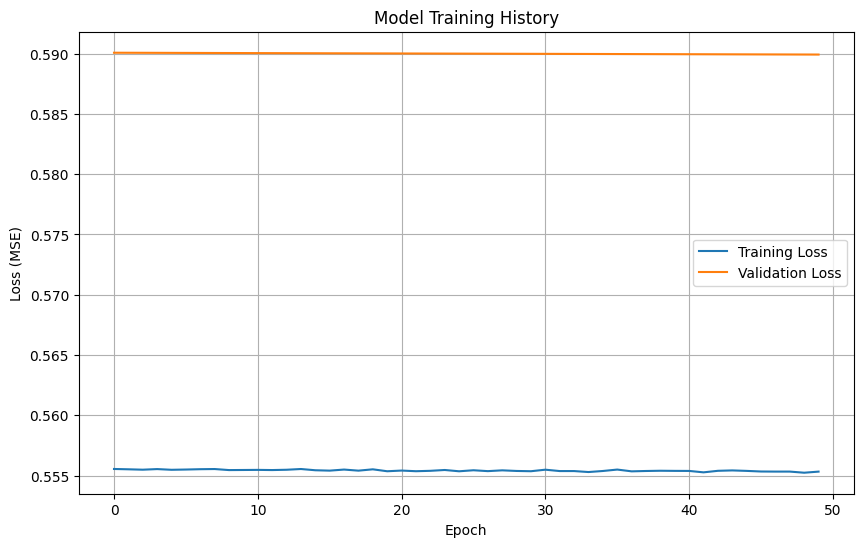

In [51]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig("training_history.png")
print("Training history plot saved as training_history.png")

In [52]:
model_save_path = f"/content/drive/MyDrive/FYP/models/SNN_{model_ver:03d}/"

os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save model
torch.save(model.state_dict(), os.path.join(model_save_path, "flagwind_model_weights.pth"))
torch.save(model, os.path.join(model_save_path, "flagwind_model.pth"))

print("✅ Model saved to Google Drive")

✅ Model saved to Google Drive


In [53]:
# model = FlagWindNet()

# # Multiple inputs must be given as a tuple of tensors
# summary(
#     model,
#     input_data=(torch.randn(1, 1024, 3), torch.randn(1, 8, 3)),
#     depth=4,   # optional: how deep to expand layers
#     verbose=1
# )


# f = io.StringIO()
# with contextlib.redirect_stdout(f):
#     summary(model, input_data=(torch.randn(1, 1024, 3), torch.randn(1, 8, 3)))

# summary_str = f.getvalue()

# plt.figure(figsize=(12, 12))
# plt.axis("off")

# # Place text inside figure coordinates (0–1 range)
# plt.figtext(0.01, 0.99, summary_str, fontsize=8, family="monospace", va="top")

# plt.savefig(os.path.join(model_save_path, "flagwind_model_summary.jpg"), bbox_inches="tight", dpi=300)
# plt.close()

# print("✅ Model summary saved as flagwind_model_summary.jpg")

Visualizing Frame -1 of Sequence 4136
Input Shape: torch.Size([1024, 3])


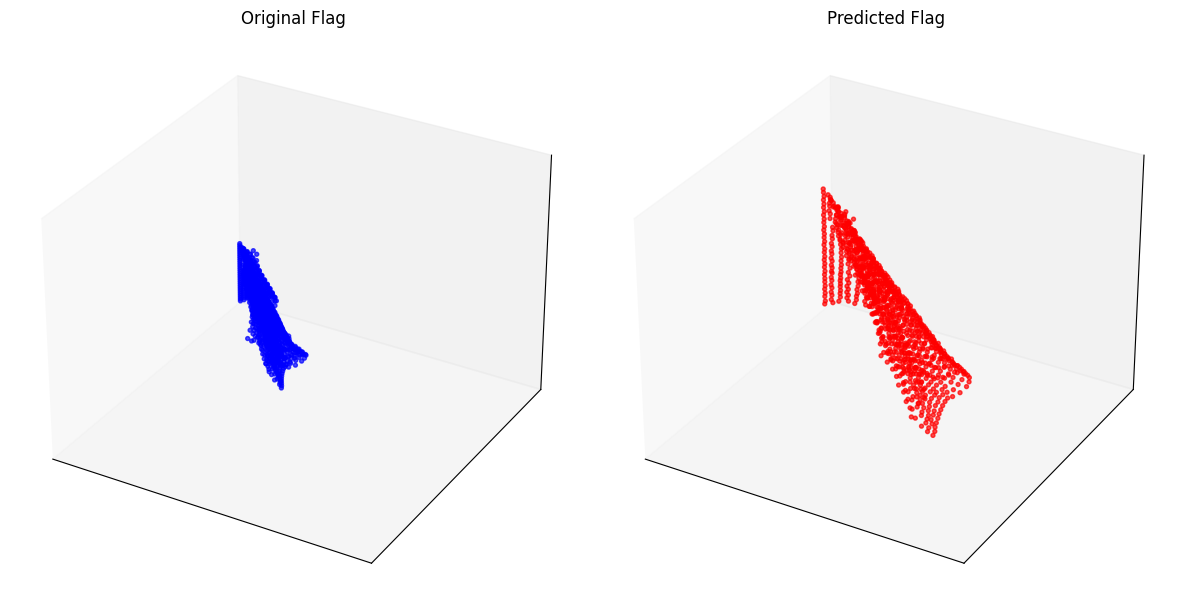

In [54]:
# 1. Pick a random sequence
idx = random.randint(0, len(test_set)-1)

# These are SEQUENCES: Shape (L, 1024, 3)
flag_seq, wind_seq, disp_seq = test_set[idx]

# 2. Add batch dimension and move to GPU
# Input Shape becomes: (1, L, 1024, 3)
flag_b = flag_seq.unsqueeze(0).to(device)
wind_b = wind_seq.unsqueeze(0).to(device)

# 3. Model Prediction
model.eval()
with torch.no_grad():
    # Output Shape: (1, L, 1024, 3) -> Squeeze to (L, 1024, 3)
    pred_disp_seq = model(flag_b, wind_b).squeeze(0).cpu()

# 4. Select a specific frame to visualize (e.g., the last frame in the sequence)
frame_idx = -1

# Get the data for that single frame
# Shape: (1024, 3)
input_pos = flag_seq[frame_idx]         # The starting position
gt_disp = disp_seq[frame_idx]           # Ground Truth displacement
pred_disp = pred_disp_seq[frame_idx]    # Predicted displacement

# 5. Calculate Absolute Positions for Visualization
# Since the model predicts displacement, add it to the input position
gt_new_pos = input_pos + gt_disp
pred_new_pos = input_pos + pred_disp

print(f"Visualizing Frame {frame_idx} of Sequence {idx}")
print(f"Input Shape: {input_pos.shape}") # Should be (1024, 3)

# 6. Visualize
# Compare Ground Truth Position vs Predicted Position
flag_vis(gt_new_pos, pred_new_pos)

In [55]:
# ================================
# 4. Rollout
# ================================

def rollout_sequence(model, dataset, iteration, max_frames, device="cuda"):
    """
    Autoregressively predicts flag positions for a given iteration.
    Returns:
        preds: (T, 1024, 3) - Predicted flag positions
        gts:   (T, 1024, 3) - Ground Truth flag positions
        diss:  (T, 1024, 3) - Predicted displacements
    """
    # Handle Subset objects (extract the underlying dataset)
    if isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset

    model.eval()

    # --- FIX: Helper to convert NumPy stats to PyTorch Tensors on device ---
    def to_tensor(stat):
        if isinstance(stat, np.ndarray):
            return torch.from_numpy(stat).float().to(device)
        return stat.to(device) # If already a tensor

    # Load Stats and ensure they are tensors
    flag_mean = to_tensor(dataset.flag_mean)
    flag_std = to_tensor(dataset.flag_std)
    wind_mean = to_tensor(dataset.wind_mean)
    wind_std = to_tensor(dataset.wind_std)
    disp_mean = to_tensor(dataset.disp_mean)
    disp_std = to_tensor(dataset.disp_std)

    L = dataset.sequence_length

    # Lists to store results
    preds_real = []
    gts_real = []
    diss_real = []

    # --- 1. Initialize History with Ground Truth (Frames 1 to L) ---
    input_flag_hist = []
    input_wind_hist = []

    for i in range(1, L + 1):
        f, w, d = dataset.load_raw_frame(iteration, i)

        # Store GTs
        gts_real.append(f)
        preds_real.append(f) # First L frames are GT
        diss_real.append(d)  # First L displacements are GT

        # Normalize and store in history for model input
        f_norm = (torch.from_numpy(f).float().to(device) - flag_mean) / (flag_std + 1e-8)
        w_norm = (torch.from_numpy(w).float().to(device) - wind_mean) / (wind_std + 1e-8)

        input_flag_hist.append(f_norm)
        input_wind_hist.append(w_norm)

    # --- 2. Autoregressive Loop (Frame L+1 onwards) ---
    # Start prediction from current state (frame L)
    current_flag_norm = input_flag_hist[-1]

    for frame in tqdm(range(L + 1, max_frames + 1)):

        # A. Load WIND for the current target frame (We always know the wind)
        # We also load GT flag/disp for comparison
        f_gt, w_raw, d_gt = dataset.load_raw_frame(iteration, frame)
        gts_real.append(f_gt)

        w_norm = (torch.from_numpy(w_raw).float().to(device) - wind_mean) / (wind_std + 1e-8)

        # B. Update History Window
        # Wind: Remove oldest, add NEW wind
        input_wind_hist.pop(0)
        input_wind_hist.append(w_norm)

        # Flag: Remove oldest, add CURRENT state (which is the prediction from previous step)
        input_flag_hist.pop(0)
        input_flag_hist.append(current_flag_norm)

        # C. Prepare Batch Input
        # Stack history to create (1, L, 1024, 3)
        x_flag = torch.stack(input_flag_hist).unsqueeze(0)
        x_wind = torch.stack(input_wind_hist).unsqueeze(0)

        # D. Predict
        with torch.no_grad():
            # Model outputs sequence of displacements
            pred_seq = model(x_flag, x_wind)

        # We only care about the LAST displacement in the sequence (t)
        pred_disp_norm = pred_seq[0, -1] # (1024, 3)

        # E. Denormalize Displacement
        pred_disp_real = pred_disp_norm * disp_std + disp_mean
        diss_real.append(pred_disp_real.cpu().numpy())

        # F. Update Position (Euler Integration)
        # New Pos = Old Pos + Displacement
        current_flag_real = preds_real[-1]
        if isinstance(current_flag_real, np.ndarray):
            current_flag_real = torch.from_numpy(current_flag_real).to(device)

        next_flag_real = current_flag_real + pred_disp_real

        # Save Prediction
        preds_real.append(next_flag_real.cpu().numpy())

        # G. Re-normalize new position for next step's history
        current_flag_norm = (next_flag_real - flag_mean) / (flag_std + 1e-8)

    return np.array(preds_real), np.array(gts_real), np.array(diss_real)

In [56]:
def compare_rollout(preds, gts, step=50):
    """
    Visualize predictions vs ground truth at given step index.
    """
    flag_pred = preds[step]
    flag_gt = gts[step]

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(flag_gt[:,0], flag_gt[:,1], flag_gt[:,2], c="green", s=8, alpha=0.7)
    ax.set_title(f"Ground Truth Frame {step}")

    ax2 = fig.add_subplot(122, projection="3d")
    ax2.scatter(flag_pred[:,0], flag_pred[:,1], flag_pred[:,2], c="red", s=8, alpha=0.7)
    ax2.set_title(f"Predicted Frame {step}")

    for a in [ax, ax2]:
        a.set_xticks([]); a.set_yticks([]); a.set_zticks([])
        a.grid(False)

    plt.show()

In [57]:
def compare_rollout_grid(preds, gts, steps):
    """
    Reuse flag_vis for multiple frames.
    Each call will produce its own figure with Original vs Predicted.
    """
    for step in steps:
        flag = torch.from_numpy(gts[step])
        pred_disp = torch.from_numpy(preds[step] - gts[step])  # displacement
        print(f"🔹 Visualizing frame {step}")
        flag_vis(flag, pred_disp)

In [58]:
# Pass 'test_set' directly. The function handles grabbing stats and the dataset.
preds, gts, diss = rollout_sequence(
    model,
    test_set,           # Pass the subset directly
    iteration=81,       # Pick a valid iteration from your test set
    max_frames=280,
    device="cuda"
)

print(f"Shapes -> Preds: {preds.shape}, GTs: {gts.shape}, Diss: {diss.shape}")

100%|██████████| 270/270 [00:00<00:00, 356.82it/s]

Shapes -> Preds: (280, 1024, 3), GTs: (280, 1024, 3), Diss: (280, 1024, 3)


🔹 Visualizing frame 1


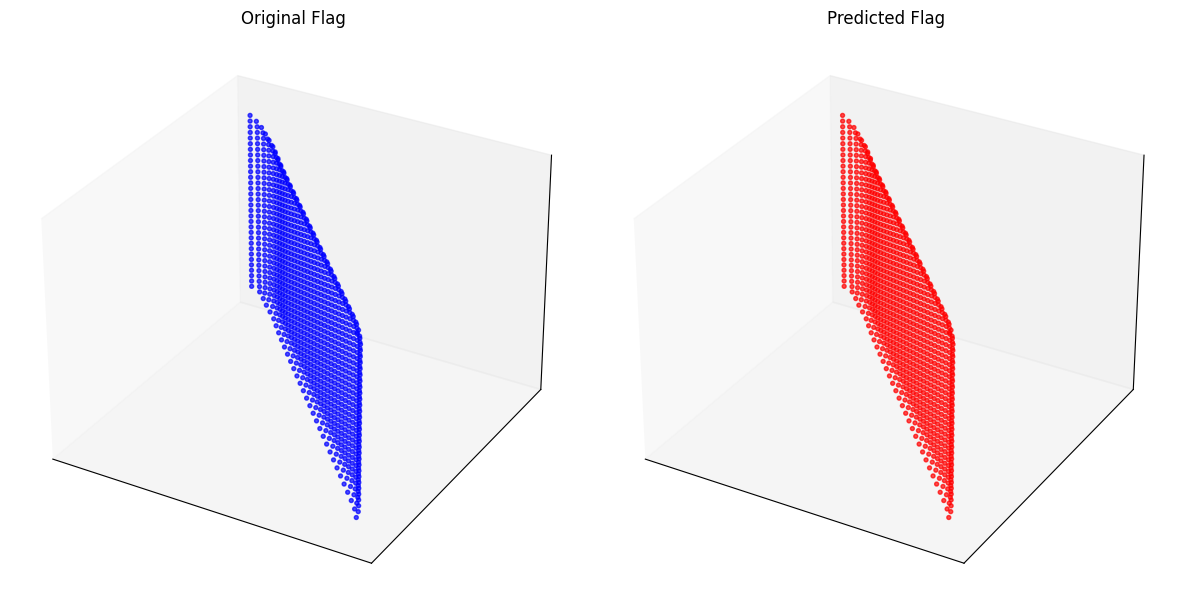

🔹 Visualizing frame 11


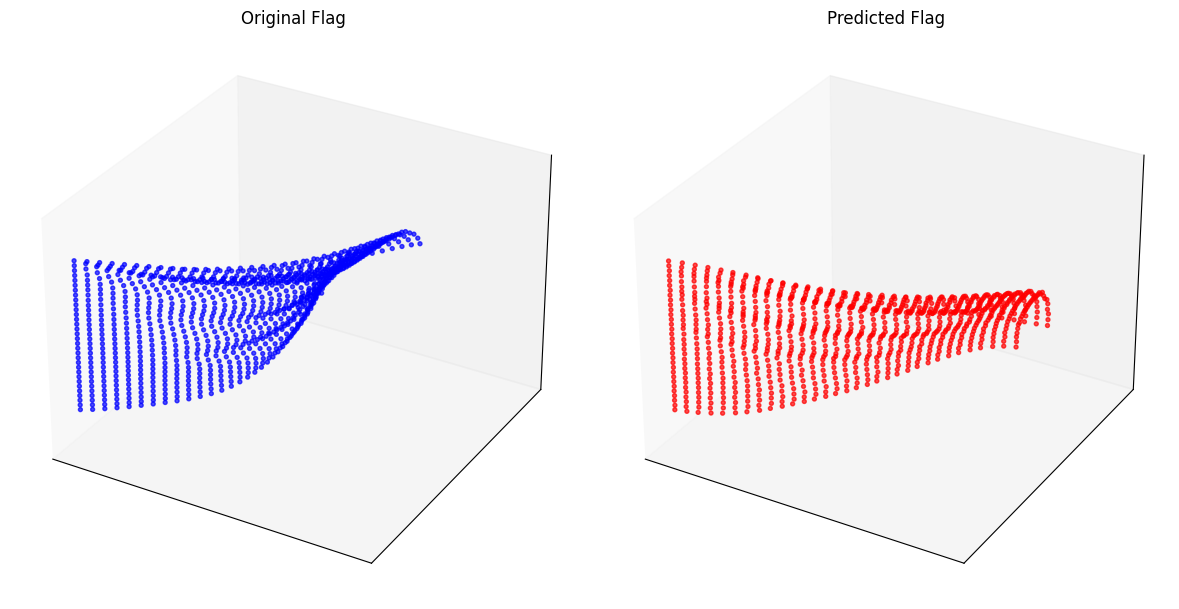

🔹 Visualizing frame 21


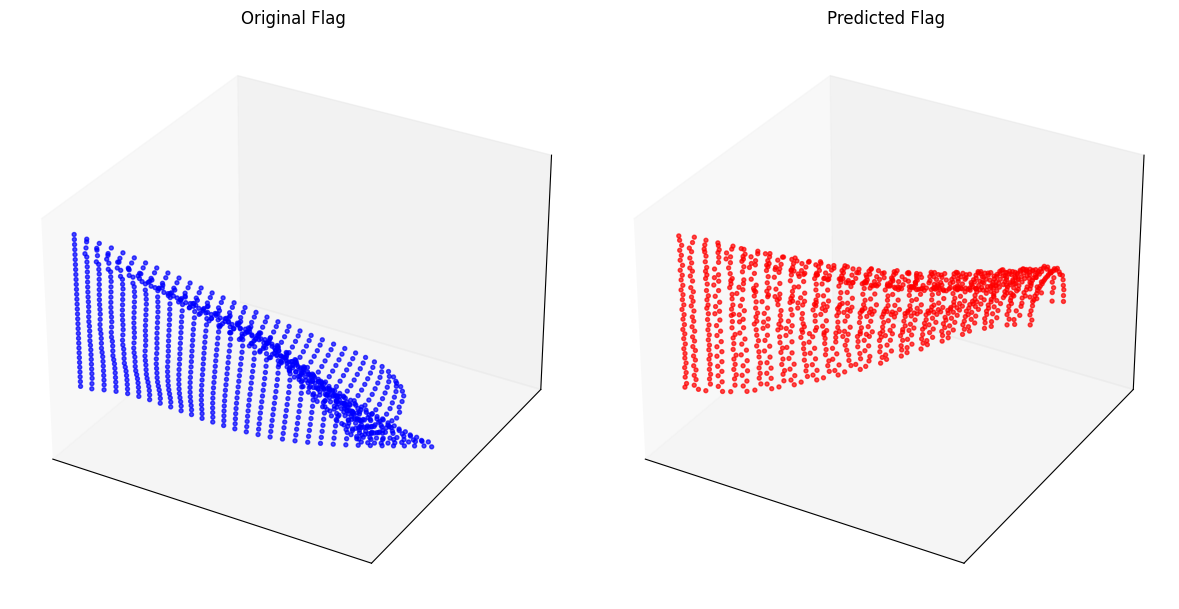

🔹 Visualizing frame 31


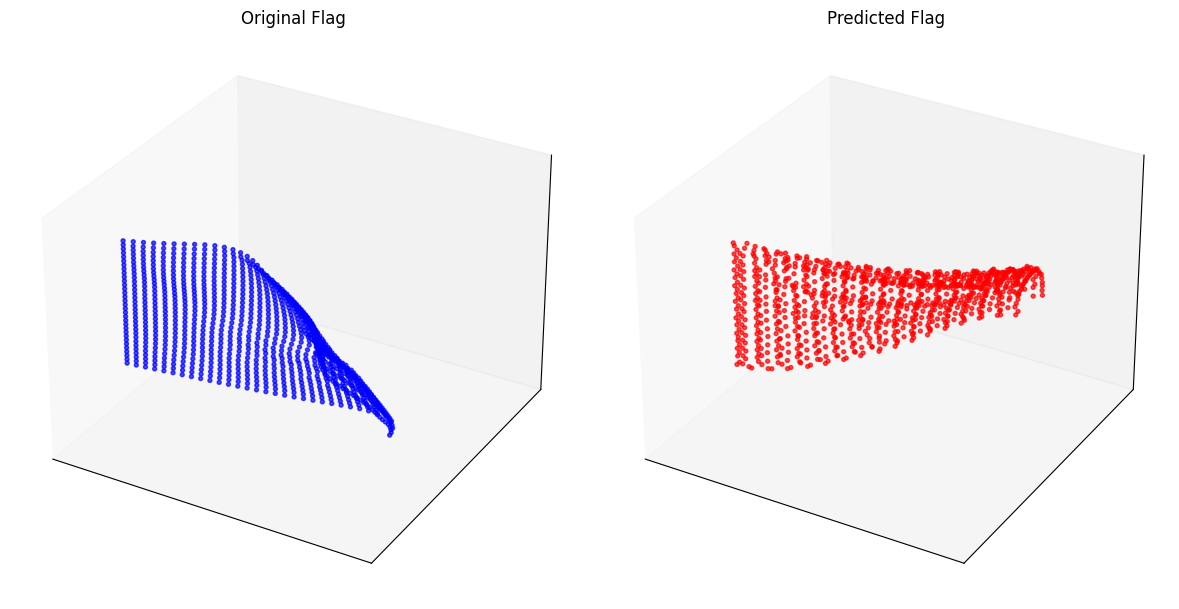

🔹 Visualizing frame 41


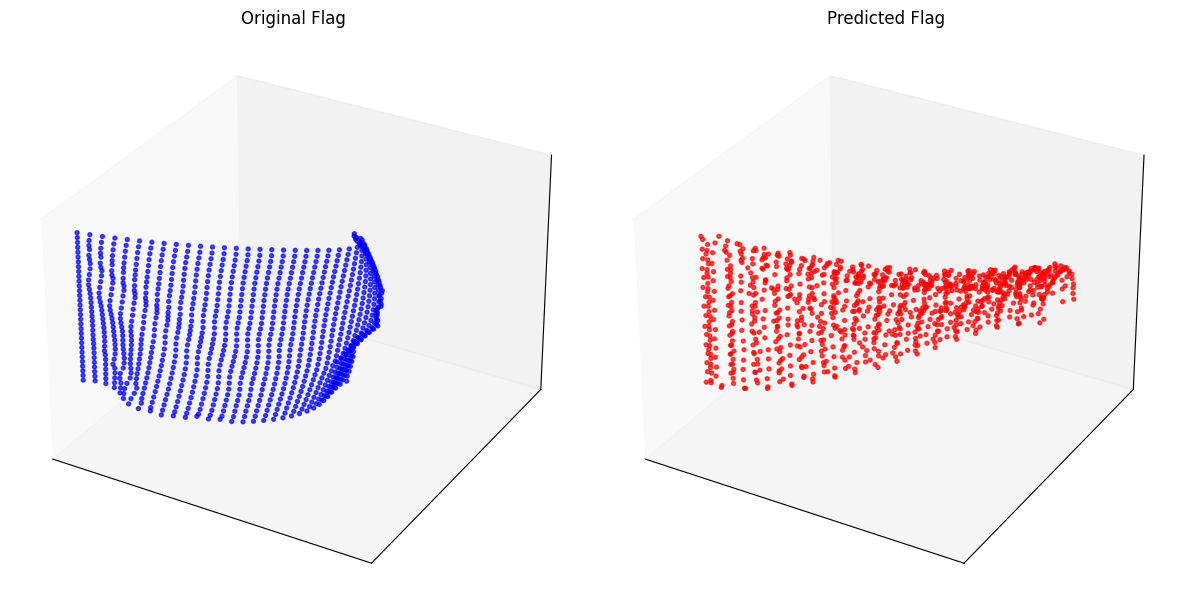

🔹 Visualizing frame 51


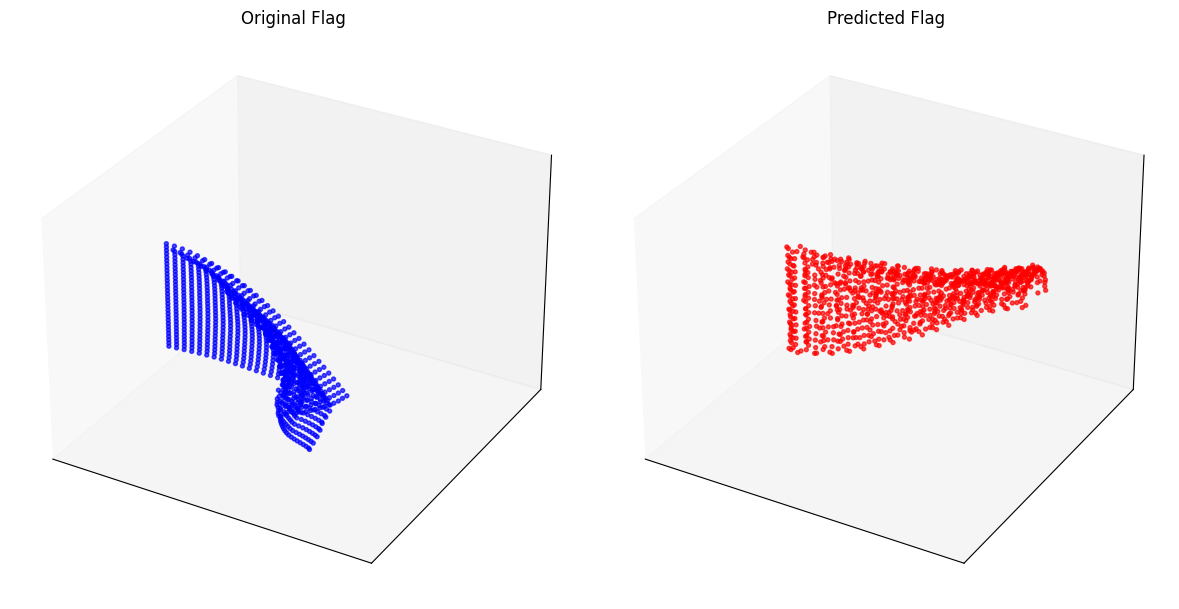

🔹 Visualizing frame 61


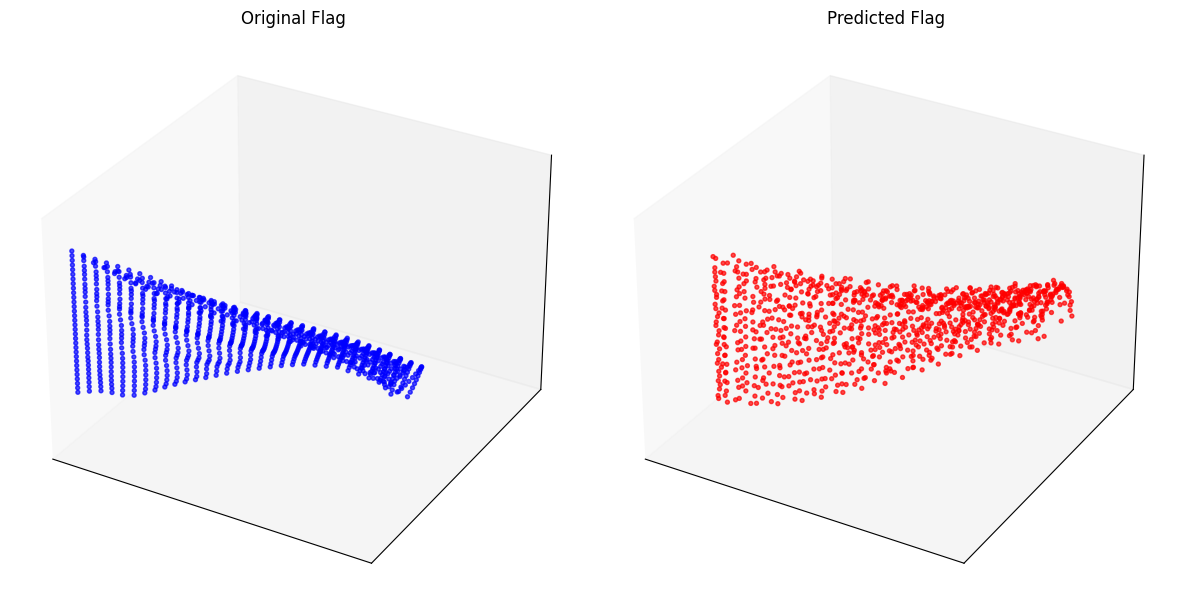

🔹 Visualizing frame 71


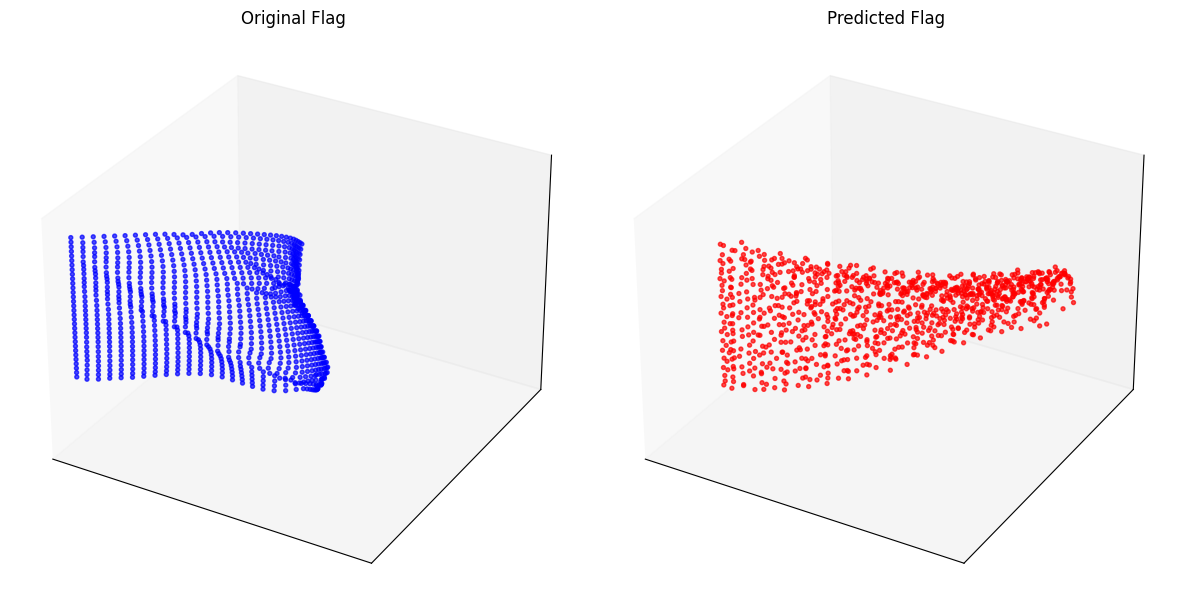

🔹 Visualizing frame 81


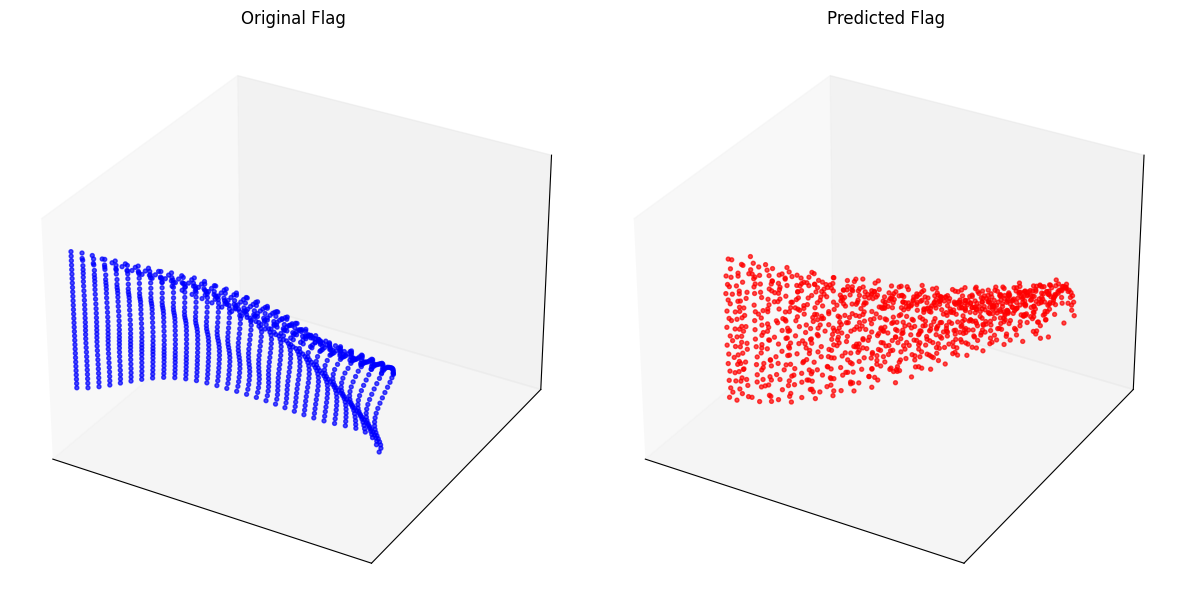

🔹 Visualizing frame 91


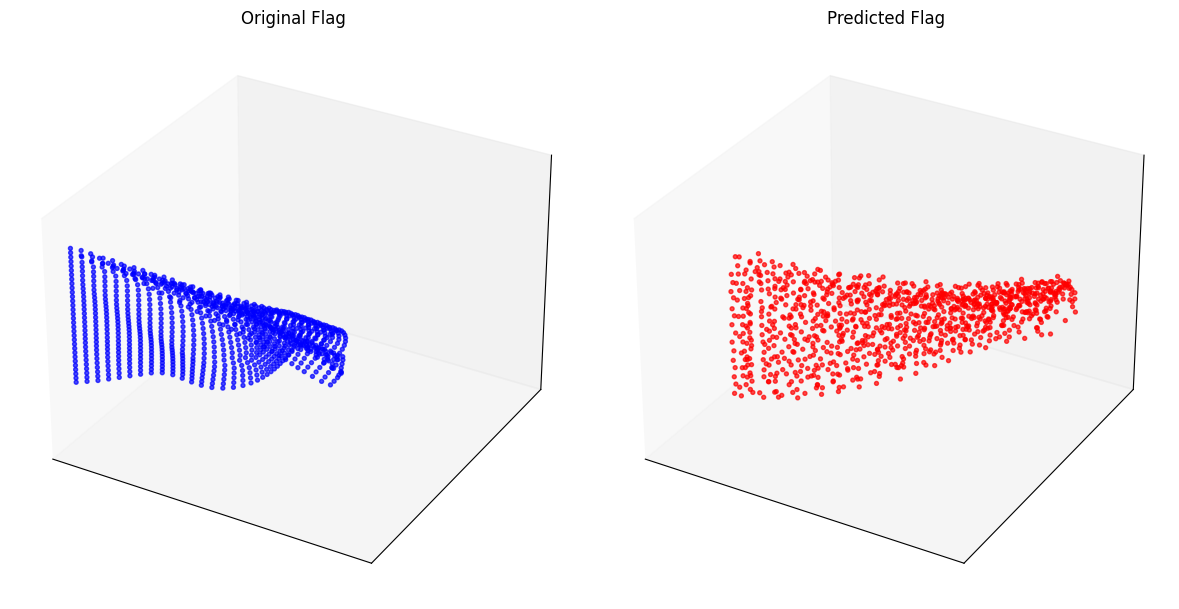

🔹 Visualizing frame 101


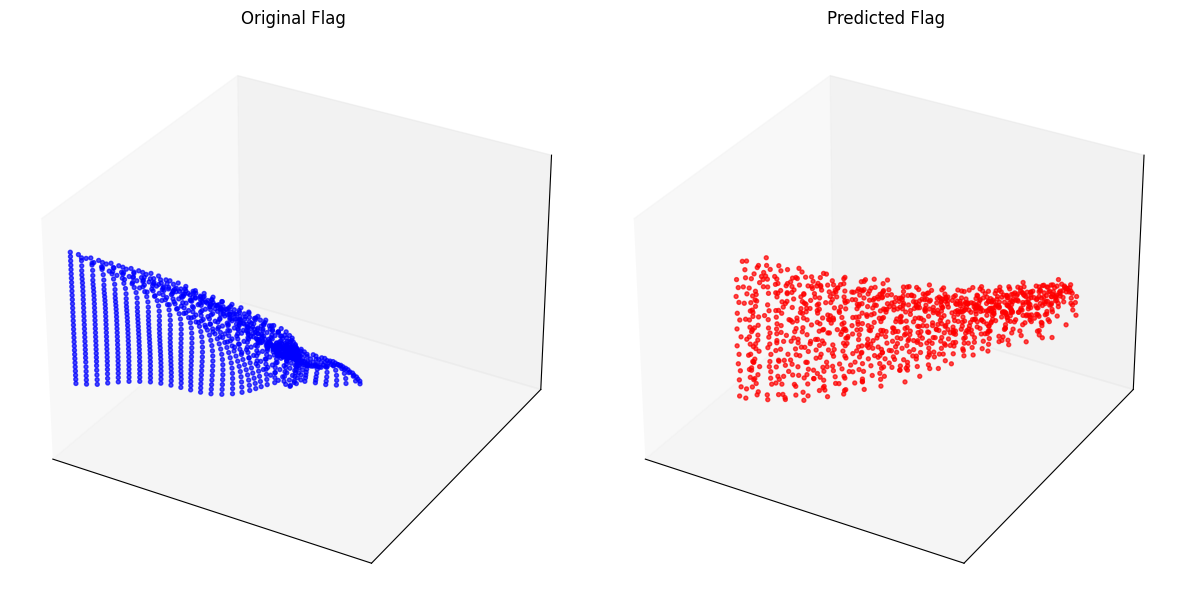

🔹 Visualizing frame 111


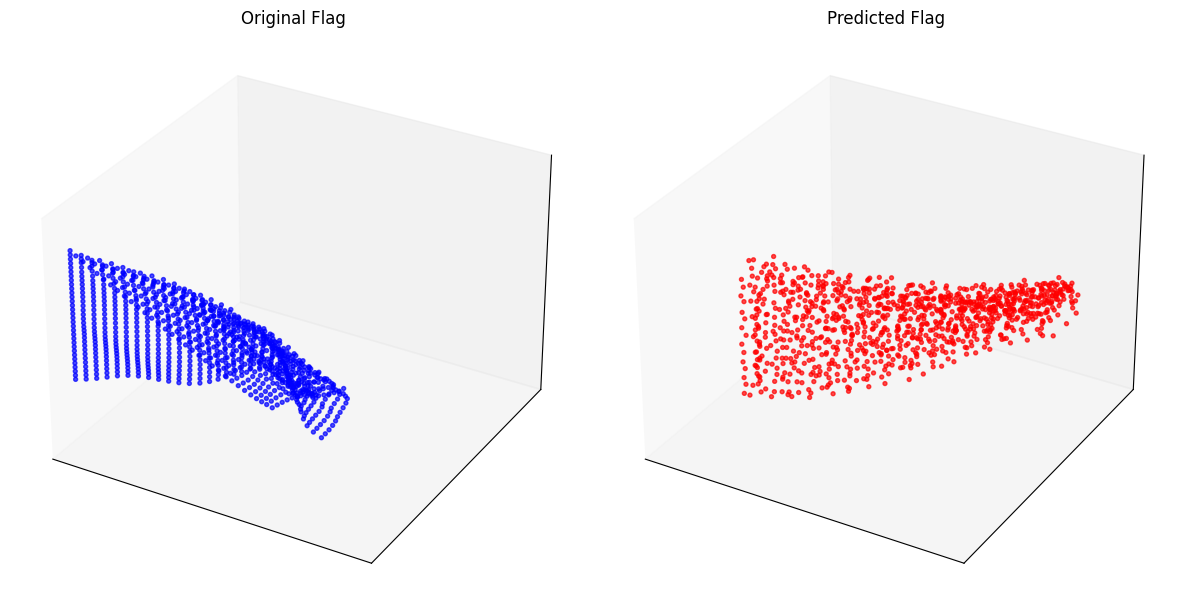

🔹 Visualizing frame 121


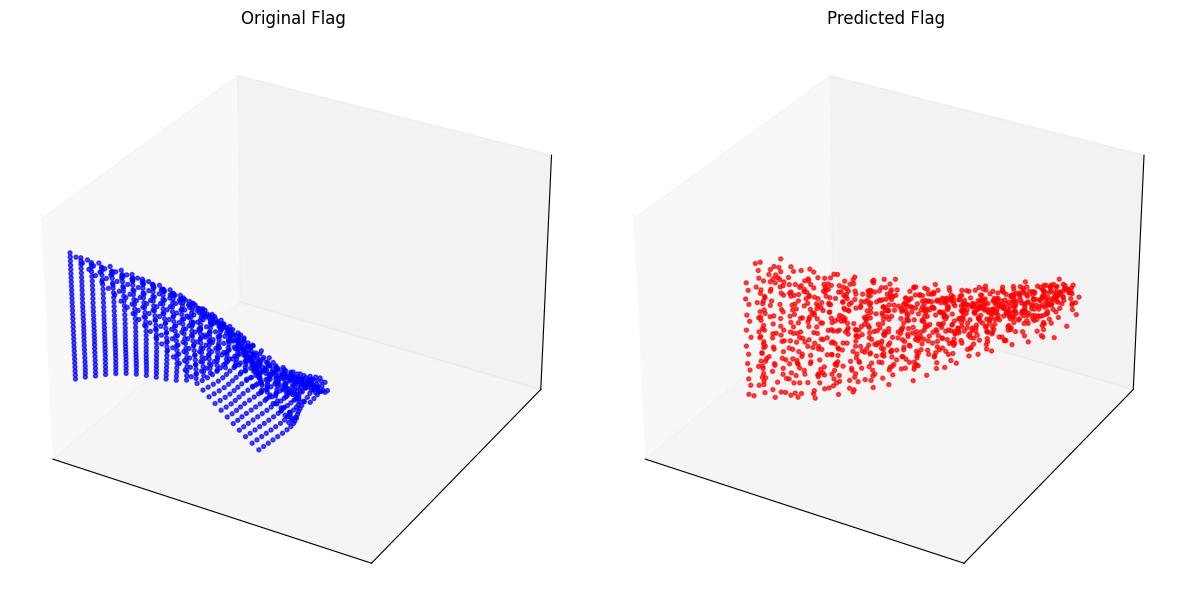

🔹 Visualizing frame 131


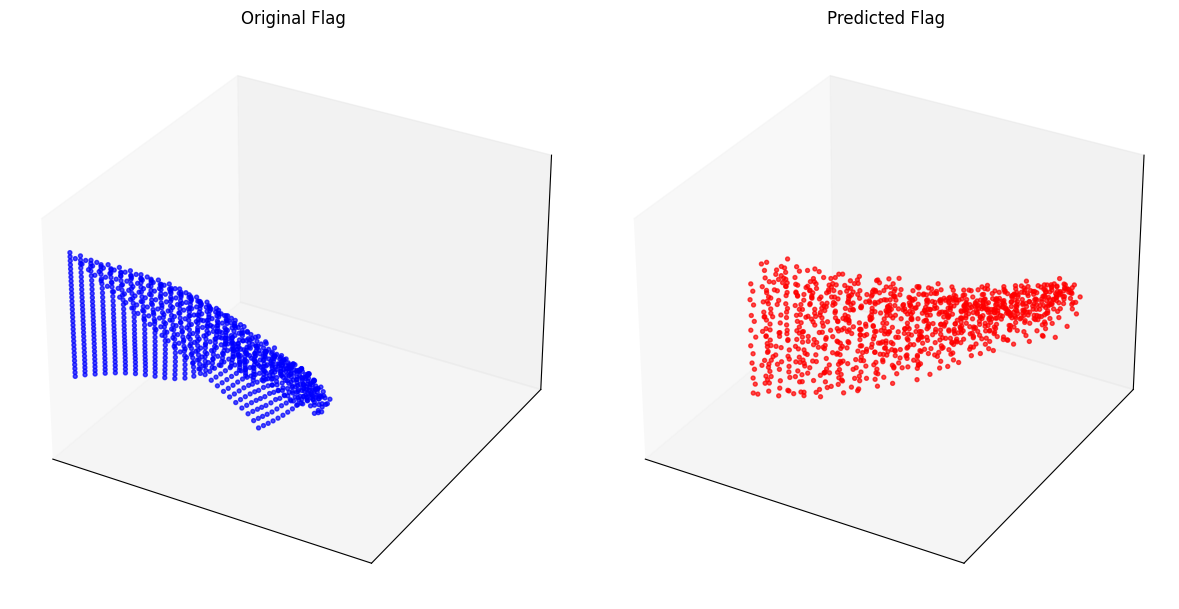

🔹 Visualizing frame 141


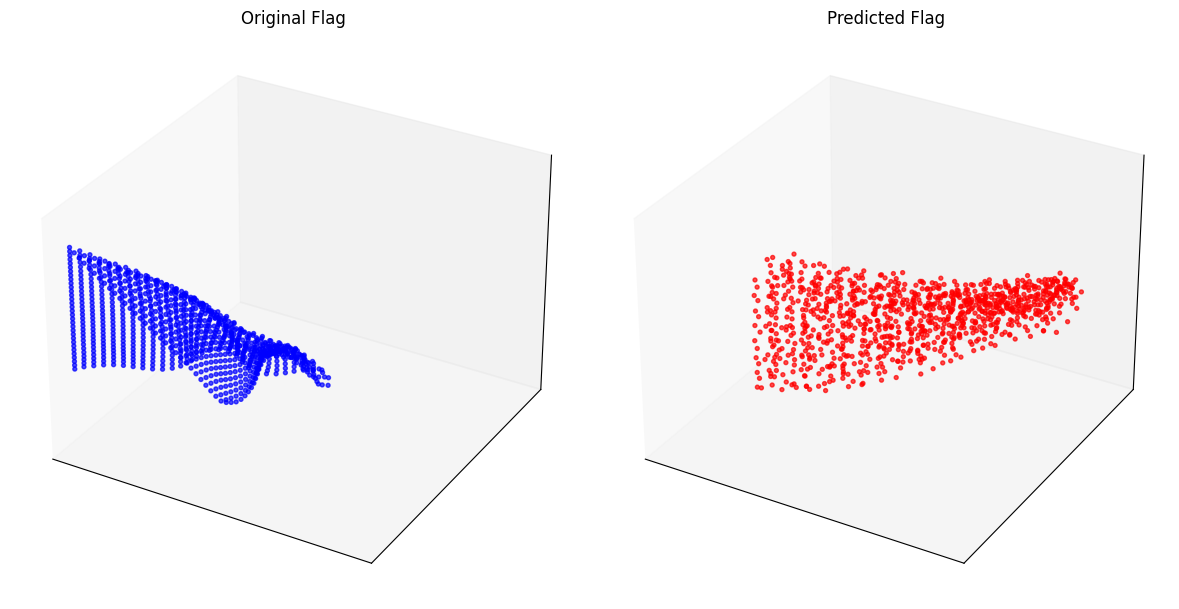

🔹 Visualizing frame 151


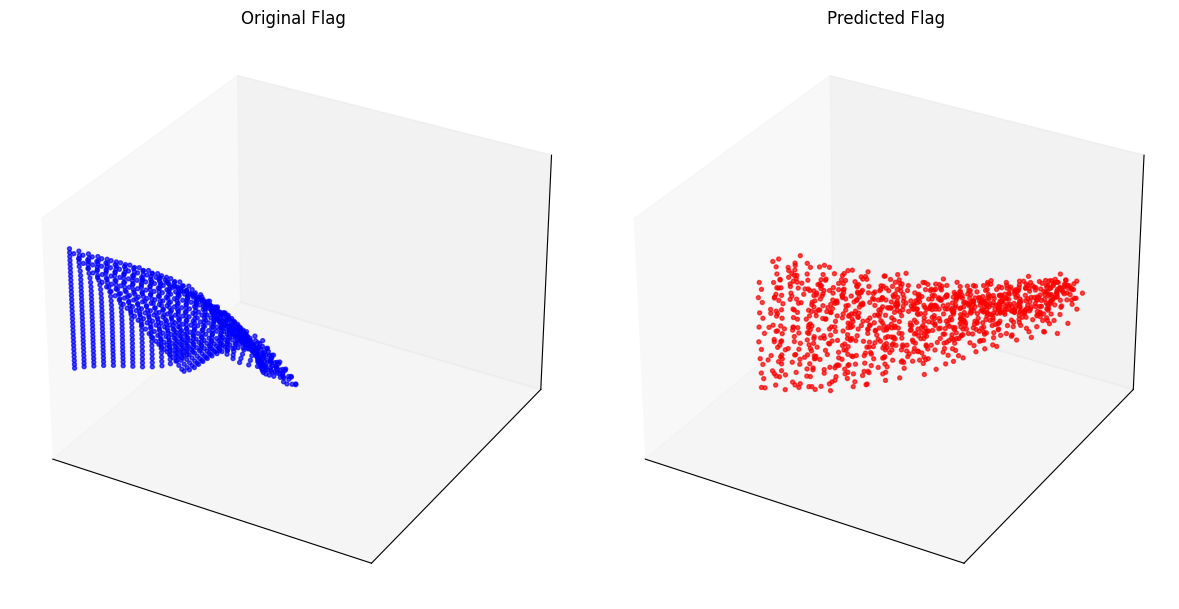

🔹 Visualizing frame 161


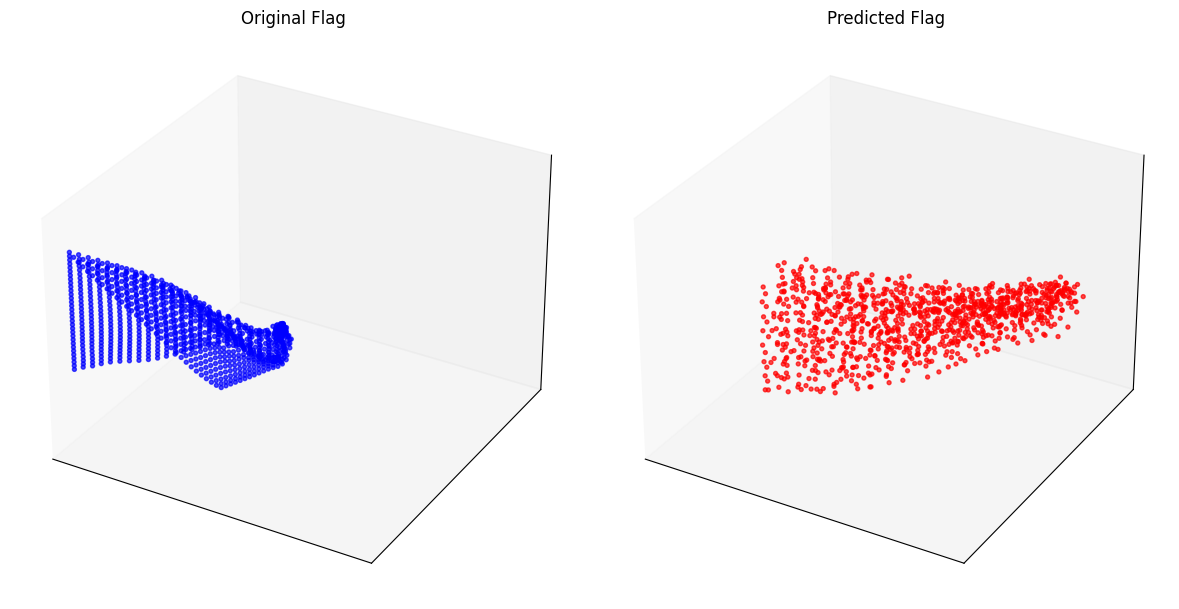

🔹 Visualizing frame 171


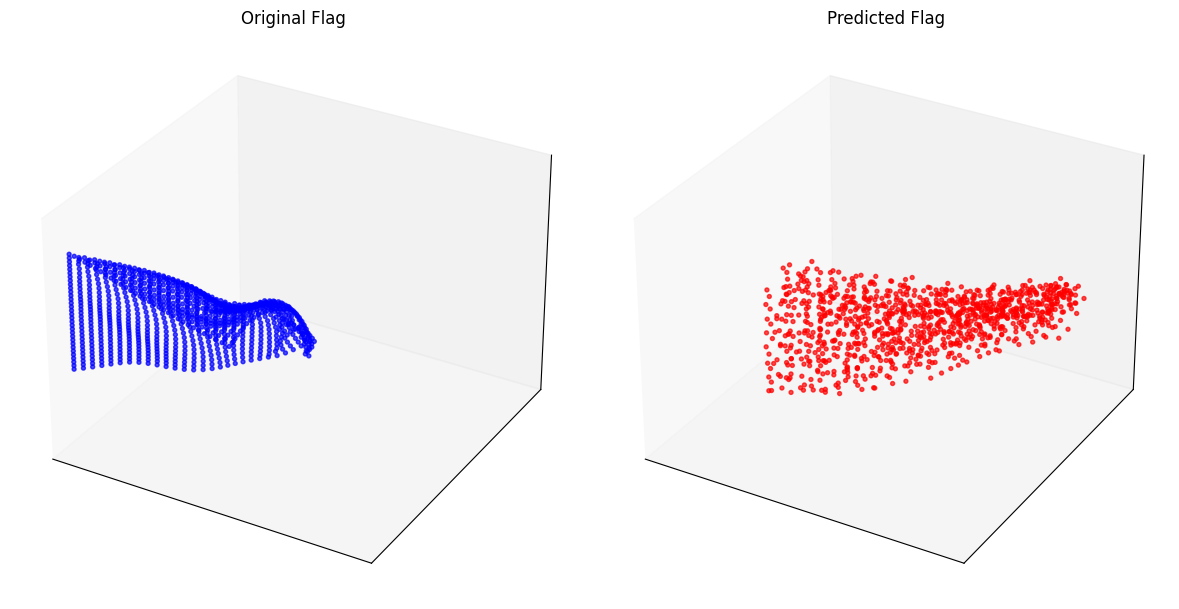

🔹 Visualizing frame 181


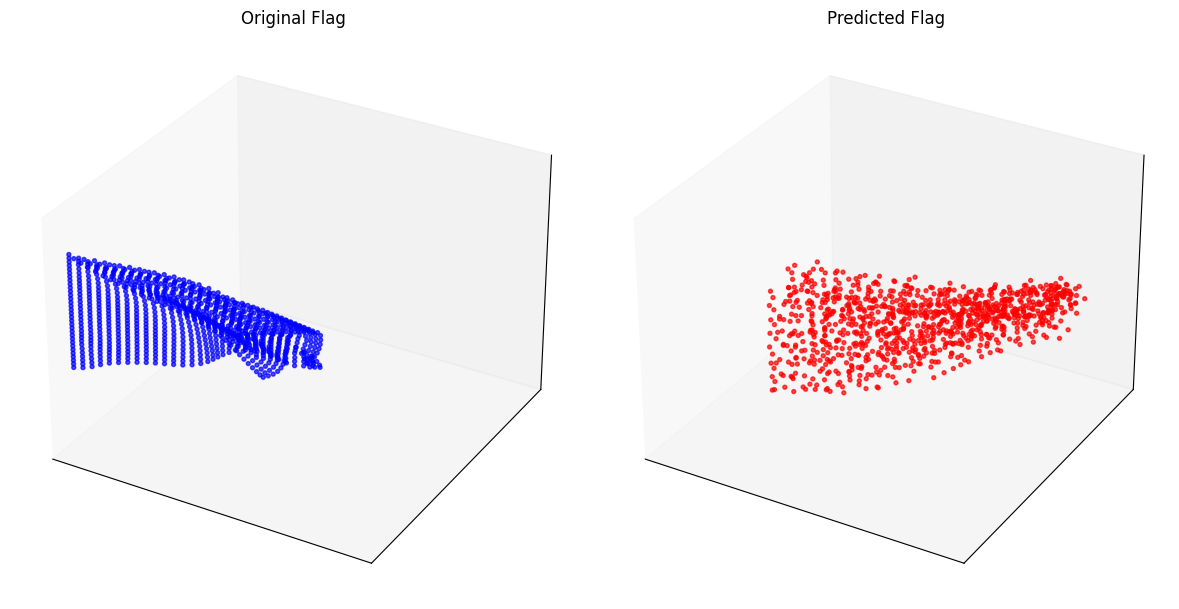

🔹 Visualizing frame 191


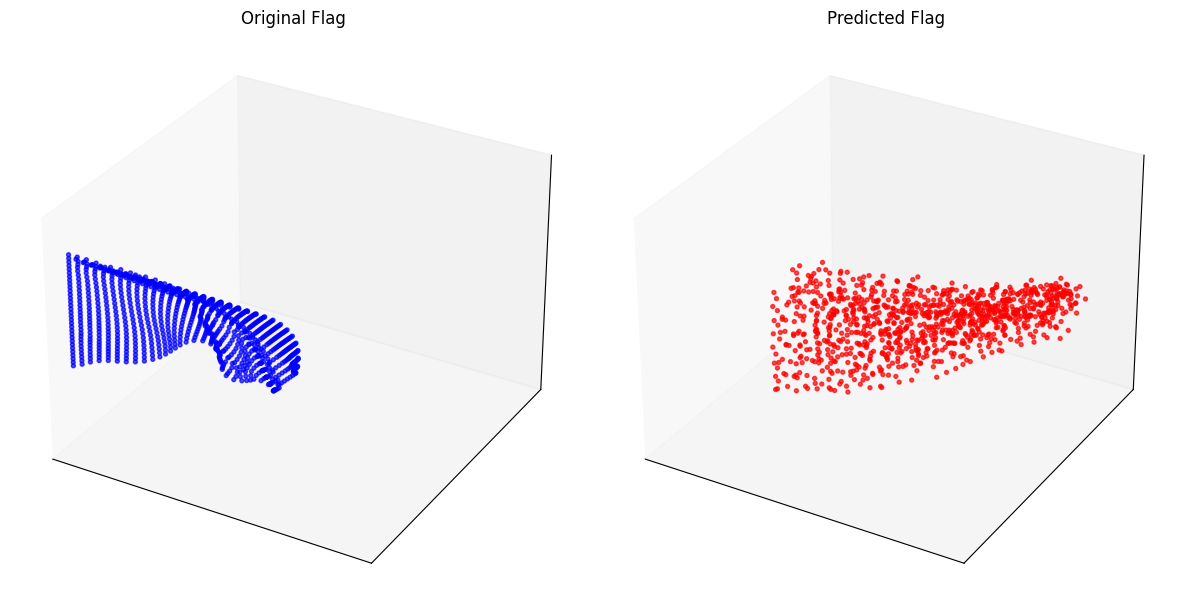

🔹 Visualizing frame 201


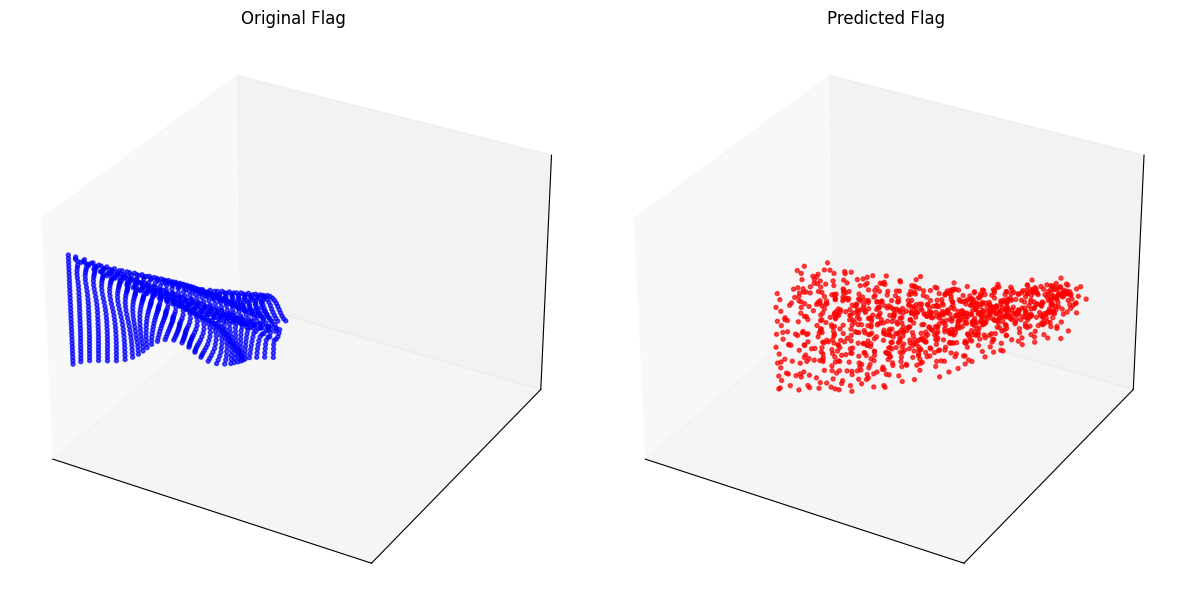

🔹 Visualizing frame 211


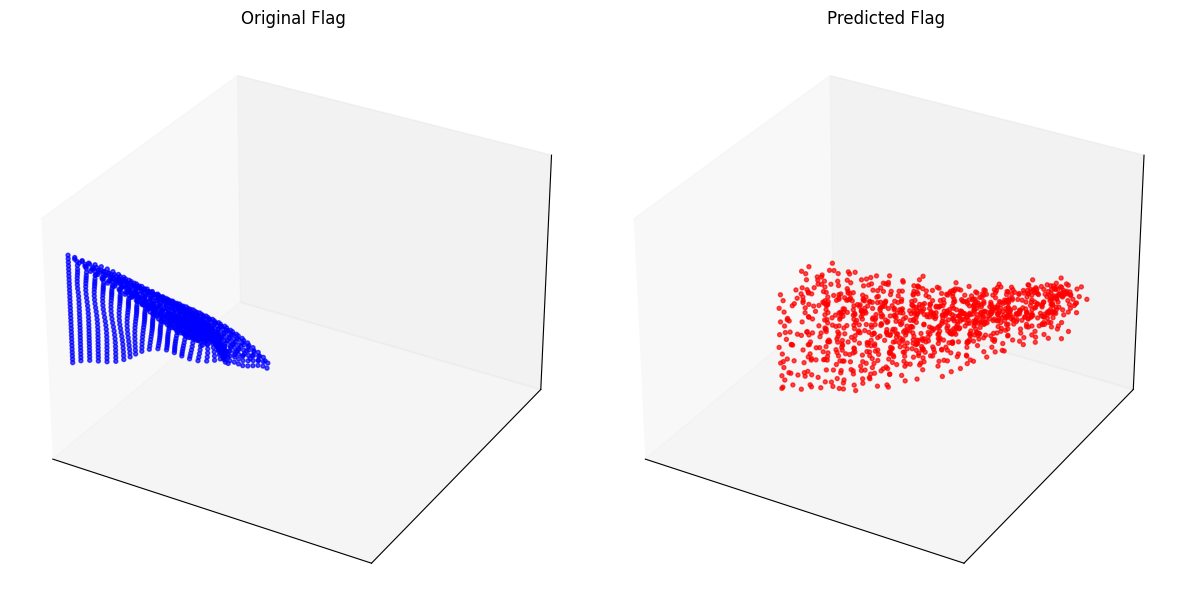

🔹 Visualizing frame 221


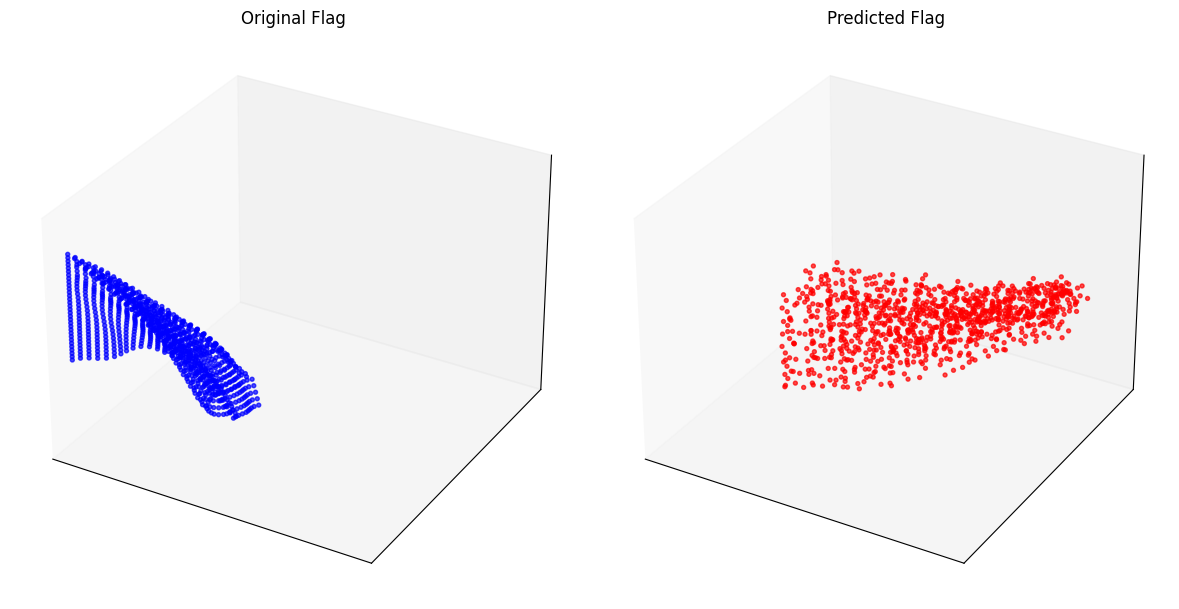

🔹 Visualizing frame 231


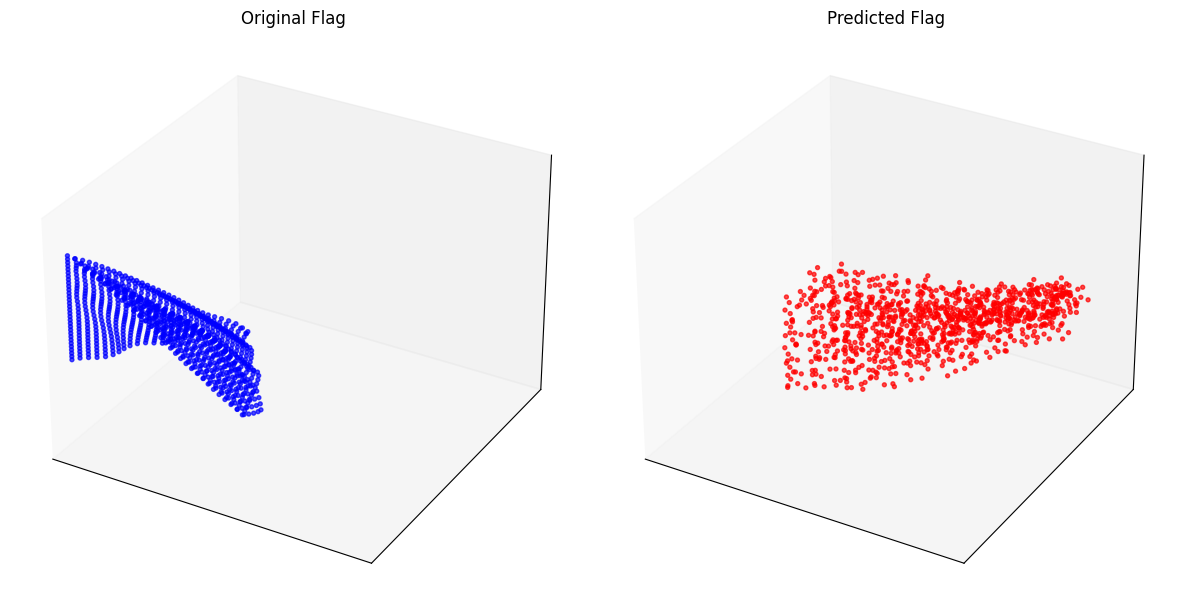

🔹 Visualizing frame 241


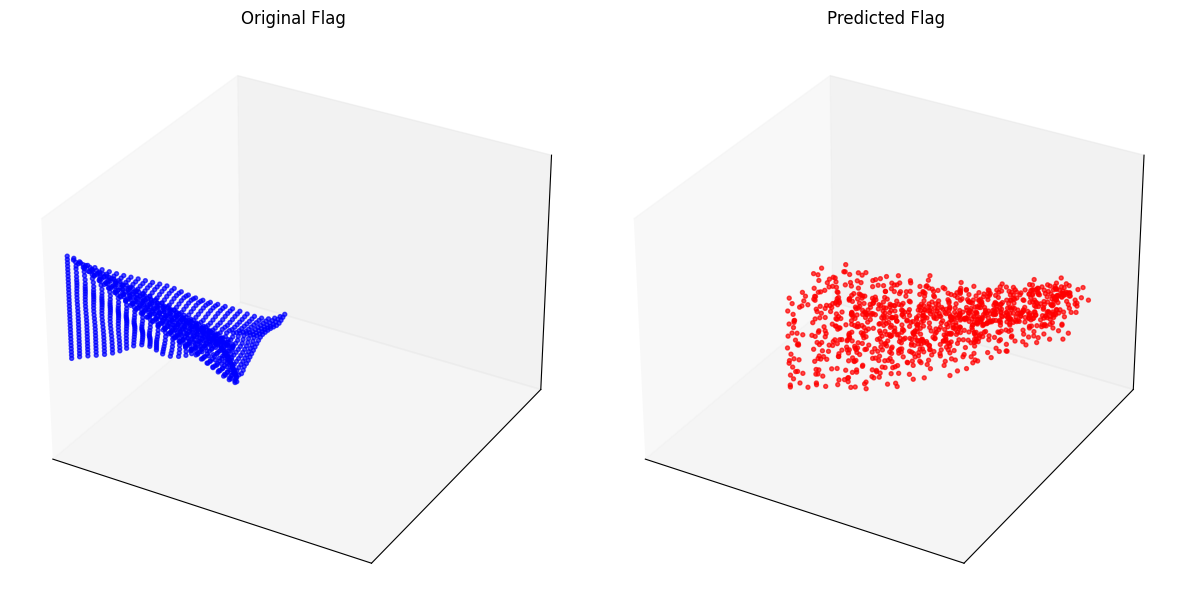

🔹 Visualizing frame 251


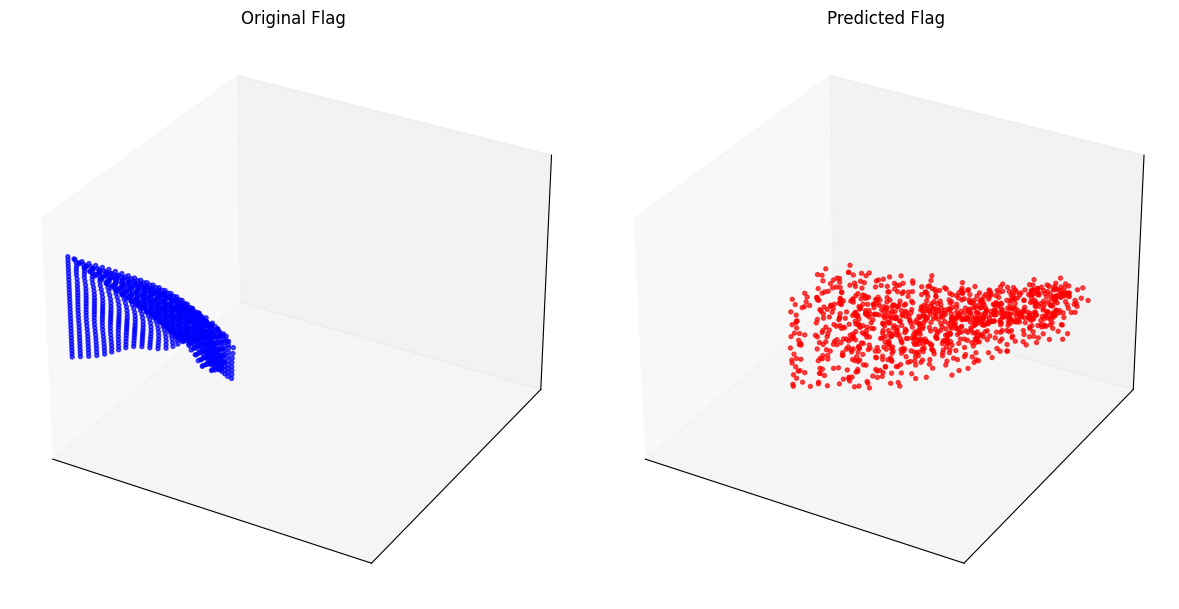

🔹 Visualizing frame 261


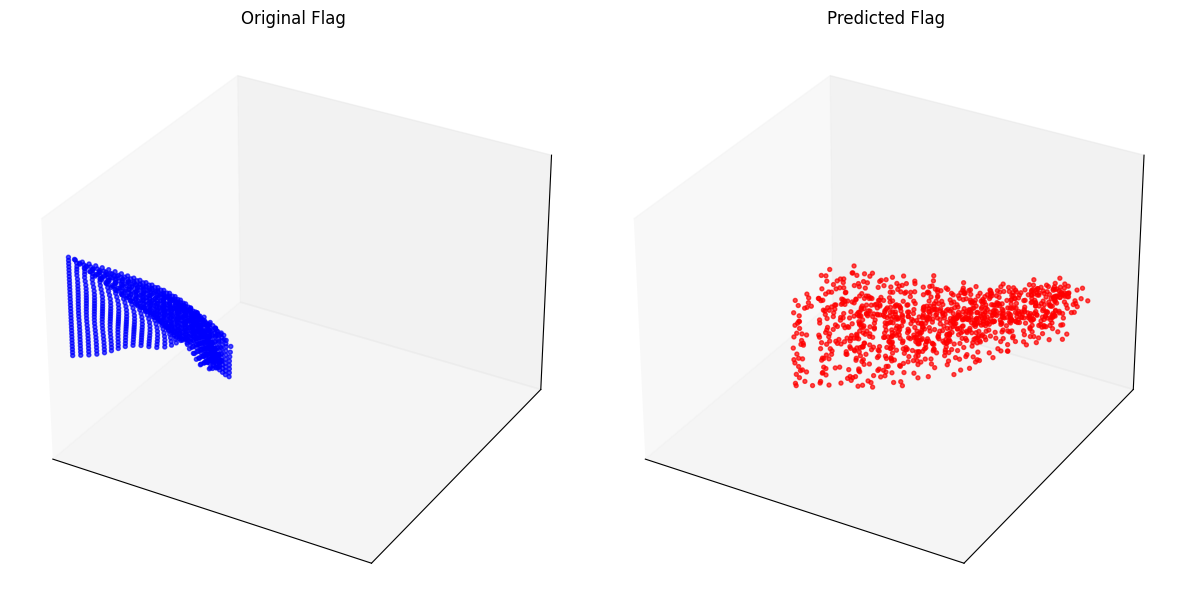

🔹 Visualizing frame 271


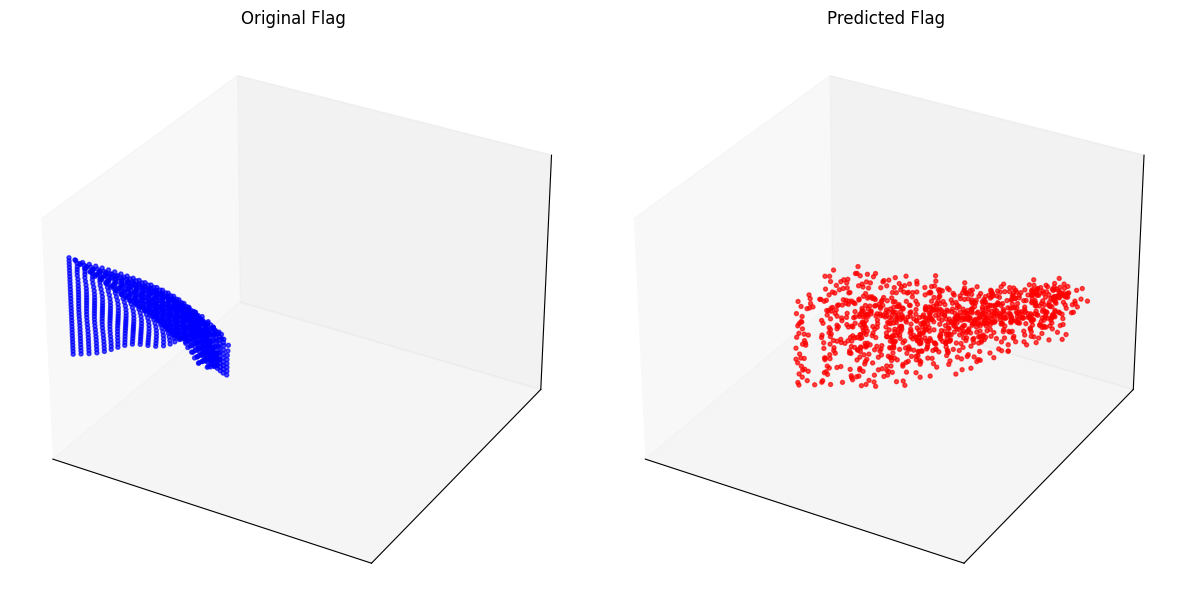

In [59]:
# Example usage
compare_rollout_grid(preds, gts, steps=range(1, 281, 10))